<h1 style='text-align: center; color: lightblue; font-size: 40px'> Neural Nets from scratch: </h1>
<h2 style='text-align: center; color: lightblue; font-size: 30px'> MNIST with fully connected neural net </h2>

In [1]:
import torch
import numpy as np

# Computer vision with MNIST

### Get the data

We'll start with MNIST. It's a simple dataset with two advantages for building NN from scratch:
* it has only one channel (no RGB)
* we can model very quickly (the data is not huge) but still get very good results

In [2]:
from torchvision.datasets import MNIST
trainset = MNIST('../../', download=True, train=True)
testset = MNIST('../../', download=True, train=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../../MNIST/raw/train-images-idx3-ubyte.gz to ../../MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../../MNIST/raw/train-labels-idx1-ubyte.gz to ../../MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../../MNIST/raw/t10k-images-idx3-ubyte.gz to ../../MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../../MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../../
    Split: Train

In [4]:
# find where the data is stored in trainset by doing trainset. +tab (or looking at the doc)
# then use .shape (like in numpy or pandas) to get it's shape
# do the same thing with the test set
trainshape = trainset.data.shape
testshape = testset.data.shape
assert trainshape == torch.Size([60000, 28, 28])
assert testshape[0] == 10000

In [5]:
import matplotlib.pyplot as plt

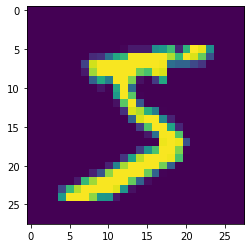

In [6]:
# amonst that data, get one picture
# then use plt.imshow() to plot it 
plt.imshow(trainset.data[0])

In [7]:
# since we are doing a fully connected NN, we don't want 28*28 square images but a 784*1 vector
train = trainset.data.reshape(60000, -1)
train.shape

torch.Size([60000, 784])

In [8]:
# do the same thing for test set
test = testset.data.reshape(10000, -1)
assert test.shape == torch.Size([10000, 784])

In [9]:
# again, use trainset. +tab to find the labels (numbers from 0 to 9)
y_train = trainset.targets
y_test = testset.targets

In [10]:
# FLoating point numbers work better with pytorch...
train.dtype

torch.uint8

In [11]:
# So we pass the data to float32 torch tensors
train = train.to(torch.float32)
test = test.to(torch.float32)

In [12]:
# VERY IMPORTANT: The data isn't normalized
m, std = train.mean(), train.std()
m, std

(tensor(33.3184), tensor(78.5675))

### < Normalization cell> - don't touch it (for now...)

A Fancy tip for commenting / un-commenting a whole cell : <br /> 
* put your cursor in the cell
* press CTRL+A to select all the cell
* press CTRL+/ to comment all the selection

Of course, you can also select only a part of the cell

In [13]:
# So we normalize it
train = (train - m) / std
test = (test - m) / std
print(train.mean(), train.std())  # 0 and 1, good

tensor(1.8892e-08) tensor(1.)


### </Normalization cell>

### define a fully connected neural net

In [14]:
def relu(x):
    return x.clamp_min(0.)

In [15]:
def model(x):
    l1 = torch.nn.Linear(784, 50)
    x = relu(l1(x))
    l2 = torch.nn.Linear(50, 10)
    x = l2(x)
    return x

In [16]:
output = model(train)
# ten predictions for every row, looks good
output.shape

torch.Size([60000, 10])

### define a loss function

In [17]:
# In a single-label classification case, we use cross-entropy:
# Don't worry if this is a lot of information for now,
# we'll learn more about loss functions in a future notebook ;) 
loss_function = torch.nn.CrossEntropyLoss()

### Forward pass

In [18]:
output = model(train)
print('output shape:', output.shape)
loss = loss_function(output, y_train)
print('loss', loss)

output shape: torch.Size([60000, 10])
loss tensor(2.3365, grad_fn=<NllLossBackward>)


### Put everything together

In [19]:
# complete the code
# parameters we can change:
EPOCHS = 35
INPUT = train
TARGETS = y_train
LR = 0.3
l1 = torch.nn.Linear(784, 50)
l1.requires_grad_()
l2 = torch.nn.Linear(50, 10)
l2.requires_grad_()

def model(x):
    return l2(relu(l1(x)))

# Training loop
for i in range(EPOCHS):
    output = model(INPUT)
    loss = loss_function(output, TARGETS)
    if i % 10 == 0:
        print(loss)
    loss.backward()
    with torch.no_grad():
        for layer in [l1, l2]:
            layer.weight -= layer.weight.grad * LR
            layer.weight.grad.zero_()
            layer.bias -= layer.bias.grad * LR
            layer.bias.grad.zero_()

tensor(2.3462, grad_fn=<NllLossBackward>)
tensor(0.8375, grad_fn=<NllLossBackward>)
tensor(0.7214, grad_fn=<NllLossBackward>)
tensor(0.5186, grad_fn=<NllLossBackward>)


In [20]:
# even with this simple model, we see the loss decrease

### Inference

In [21]:
def accuracy(pred, targs):
    return float((pred.argmax(dim=-1) == targs).sum()) / float(len(pred))

In [22]:
output = l2(relu(l1(test)))

In [23]:
accuracy(output, y_test)

0.9081

~ 10% accuracy. It didn't work... Why ? Well go at the top of the notebook and un-comment the normalization cell !

...

after normalizing the data, we get 90% accuracy (random would be 10%, as there are 10 classes), our model is definitely learning something.

# Problems

### Number of parameters

We've been using a fully connected neural net on 28*28 images. Our first layer had 50 neurons

In [24]:
l1.weight.shape, l1.weight.shape[0] * l1.weight.shape[1]

(torch.Size([50, 784]), 39200)

So we are using 39200 parameters for a 28*28 image ! 
And that's only for one layer ! 

Now let's take your regular 1024 * 1024 * 3 pixel image, and run than through a 50 neurons hidden layer :

In [25]:
# 157 millions parameters, and that's only your first layer...
"{:,}".format(1024 * 1024 * 3 * 50)

'157,286,400'

In [26]:
# try the training loop above with 200620 instead of 50 to see what happens !
157286400 / 784 

200620.4081632653

### Interpretability ? 

When we take the exact same pixels but move their position on the picture, the result is different :

tensor(7) tensor(7)


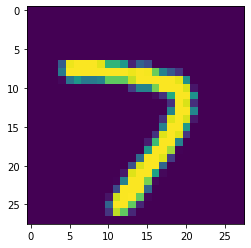

In [27]:
index = 17
seven = test.data[index].reshape(28,28)
plt.imshow(seven)
print(l2(relu(l1(test.data[index]))).argmax(dim=-1) , y_test[index])

torch.Size([28, 15])

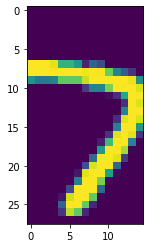

In [28]:
cut_seven = seven[:, 6:21]
plt.imshow(cut_seven.numpy())
cut_seven.shape

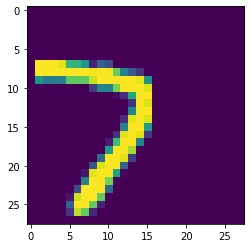

In [29]:
shifted_seven = torch.zeros(28,28)
shifted_seven[:,:] = -0.4241
shifted_seven[:,1:16] = cut_seven
plt.imshow(shifted_seven.numpy())

In [30]:
print(l2(relu(l1(shifted_seven.reshape(-1)))).argmax(dim=-1))

tensor(1)


Visual Example
@Vecanoi
https://www.youtube.com/watch?v=GtglKSYA6RY&feature=youtu.be